# Reaction-diffusion, metamodeling - HyperPINN - diffrax solver

$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x)=D\Delta u(t,x) + u(t,x)(r - \gamma u(t,x)), t\geq 0, x\in \Omega, \Omega=[0, 50]^2\\
\frac{\partial u(t,x)}{\partial n}\Big|_{x\in\partial\Omega}=\nabla u(t,x)\cdot n=0, t\geq0,\text{Neumann condition},\\
u(0,x)=u_0(x),x\in \Omega
\end{cases}
$$

In all that follows,

- $\gamma=1$
- $D$ is a scalar in $[0.05, 1.]$ homogeneous in space and time
- $r$ is a scalar in $[0.05, 0.15]$ homogenous in space and time

**We want to build a metamodel and thus, learn the solution $u(t, x)$ of the above problem for all $D$ and for all $r$. To do so, we will use an HyperPINN [https://arxiv.org/pdf/2111.01008.pdf]. Such architectures are available in jinns. The results are compared with a resolution using diffrax**

**Note that for a more peaked initial condition one would require hard constraint on the PINN or RAR sampling on the initial condition**



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable


Import our package

In [3]:
import jinns


/home/nicolas/Recherche/INRAE/PINN/jinns/jinns/data/_display.py:18: SyntaxWarning: invalid escape sequence '\O'
  """Generic function for plotting functions over rectangular 2-D domains


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)


Data Generator

In [5]:
n = 1000
nb = 500
nt = 1000
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 32
dim = 2
xmin = 0
xmax = 50
ymin = 0
ymax = 50
tmin = 0
tmax = 1
method = "uniform"

Tmax = 50
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin, ymin),
    (xmax, ymax),
    tmin,
    tmax,
    method,
)

Initial condition

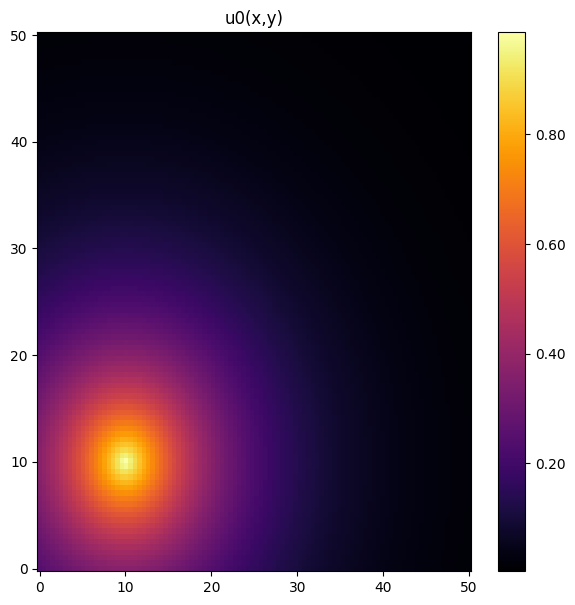

In [6]:
from jax.scipy.stats import norm
sigma_init = 1 * jnp.ones((2))
mu_init = jnp.array([10., 10.]) #jnp.array([25 / xmax, 25 / ymax])

def u0(x):
    return jnp.exp(-jnp.linalg.norm(x - mu_init) / 10.)

v_u0 = jax.vmap(u0)

nx, ny = 100, 100
val_xy_data = [
    jnp.linspace(xmin, xmax, nx),
    jnp.linspace(ymin, ymax, ny)
              ]

jinns.data.plot2d(
    fun=u0,
    xy_data=val_xy_data,
    title="u0(x,y)"
)

HyperPINN creation. The architecture of the hypernetwork must have inputs equal to the fed hyperparameters (equation parameters) [**must be provided carefully by the user as the `hypernet_input_size` variable**] and outputs equal to the total number of parameters of the PINN network [**automatically fed by jinns internally**]  

In [7]:
eqx_list = [
    [eqx.nn.Linear, 3, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 1],
    #[jax.nn.softplus]
]

eqx_list_hyper = [
    [eqx.nn.Linear, 2, 32], # input is of size 2 for scalar D and scalar r
    [jax.nn.tanh],
    [eqx.nn.Linear, 32, 32],
    [jax.nn.tanh],
    [eqx.nn.Linear, 32, 32],
    [jax.nn.tanh],
    [eqx.nn.Linear, 32, 32],
    [jax.nn.tanh],
    [eqx.nn.Linear, 32, 32],
    [jax.nn.tanh],
    [eqx.nn.Linear, 32, 32],
    [jax.nn.tanh],
    [eqx.nn.Linear, 32, 1000], # 1000 is a random guess, it will automatically be filled with the correct value
]
key, subkey = random.split(key)

hyperparams = ["D", "r"]
hypernet_input_size = 2

dim_x = 2

u = jinns.utils.create_HYPERPINN(subkey, eqx_list, "nonstatio_PDE", hyperparams, hypernet_input_size, dim_x, eqx_list_hyper=eqx_list_hyper)

In [8]:
init_nn_params = u.init_params()

Additional batch for the parameters

In [9]:
method = "grid"
key, subkey = random.split(key)
np = 1024
param_batch_size = 32*32 # must be equal to omega_batch_size * time_batch_size !
param_train_data = jinns.data.DataGeneratorParameter(
    subkey,
    np,
    param_batch_size,
    {"D":(0.05, 1.), "r":(0.05, 0.15)},
    method,
)

### True model parameters and parameter initialization

In [10]:
D = 0.5
g = 1.
r = 0.1


Note that we feed the parameters obtained from the additional batch into the classical dictionary of parameters

In [11]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        **param_train_data.get_batch(), # The additional batch is a dict
        "g":jnp.array([g]),
    }
}

The spatial heterogeneity of $r$ is introduced through a user defined function which recreates the spatial map

### Loss construction

In [12]:
from jinns.loss._DynamicLossAbstract import PDENonStatio
from jinns.loss._operators import _laplacian_rev

class FisherKPP_reparametrized(PDENonStatio):
    r"""
    Return the Fisher KPP dynamic loss term. Dimension of :math:`x` can be
    arbitrary

    .. math::
        \frac{\partial}{\partial t} u(t,x)=D\Delta u(t,x) + u(t,x)(r(x) - \gamma(x)u(t,x))

    """

    def __init__(self, Tmax=1, eq_params_heterogeneity=None):
        super().__init__(Tmax, eq_params_heterogeneity)

    @PDENonStatio.evaluate_heterogeneous_parameters
    def evaluate(self, t, x, u, params):
        # Note that the last dim of u is nec. 1
        u_ = lambda t, x: u(t, x, params)[0]

        du_dt = jax.grad(u_, 0)(t, x)

        lap = _laplacian_rev(t, x, u, params)[..., None]

        return du_dt + self.Tmax * (
            - params["eq_params"]["D"] * lap
            - params["eq_params"]["r"] * u(t, x, params)
            * (
                1 - params["eq_params"]["g"] * u(t, x, params)
            )
        )

fisher_dynamic_loss = FisherKPP_reparametrized(Tmax=Tmax)

In [13]:
loss_weights = {"dyn_loss":1., "initial_condition": 1. , "boundary_loss":1.}

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="neumann",
    initial_condition_fun=u0,
    norm_key=None,
    norm_borders=None,
    norm_samples=None
)


In [14]:
from jinns.data import append_param_batch

losses_and_grad = jax.value_and_grad(loss, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    #train_data.get_batch(),#
    append_param_batch(train_data.get_batch(), param_train_data.get_batch())
)


l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")


total loss: 0.5225527286529541
Individual losses: {'boundary_loss': '0.00', 'dyn_loss': '0.48', 'initial_condition': '0.04', 'norm_loss': '0.00', 'observations': '0.00', 'sobolev': '0.00'}


### Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [15]:
params = init_params


In [16]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)

In [17]:
n_iter = 30000

In [18]:
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    param_data=param_train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)

  0%|          | 0/30000 [00:00<?, ?it/s]

Iteration 0: loss value = 0.2738240659236908
Iteration 1000: loss value = 0.02841244637966156
Iteration 2000: loss value = 0.0682191252708435
Iteration 3000: loss value = 0.05303410440683365
Iteration 4000: loss value = 0.06861577928066254
Iteration 5000: loss value = 0.002017198596149683
Iteration 6000: loss value = 0.0025555030442774296
Iteration 7000: loss value = 0.001785006490536034
Iteration 8000: loss value = 0.002060959115624428
Iteration 9000: loss value = 0.0018815032672137022
Iteration 10000: loss value = 0.0014017466455698013
Iteration 11000: loss value = 0.0021254848688840866
Iteration 12000: loss value = 0.0013340828008949757
Iteration 13000: loss value = 0.0015450911596417427
Iteration 14000: loss value = 0.001915693050250411
Iteration 15000: loss value = 0.0014393129386007786
Iteration 16000: loss value = 0.0015398375689983368
Iteration 17000: loss value = 0.00120647344738245
Iteration 18000: loss value = 0.002170046092942357
Iteration 19000: loss value = 0.001365961972

### Results

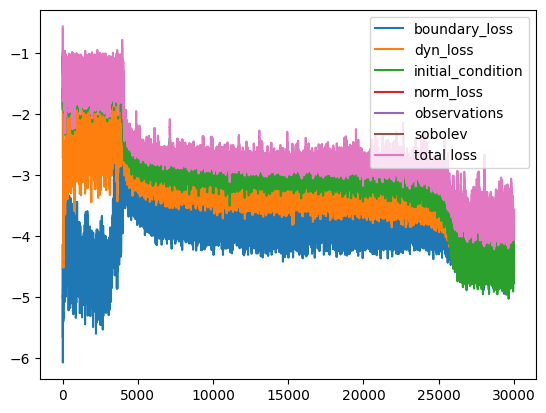

In [19]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


## Plot the PDE solution learned by the PINN for $D=1$ and $r=0.15$

In [33]:
t_ind = jnp.array([0, 1, 10, 25, 48, 50])
times = jnp.round(t_ind * 1. / Tmax, decimals=2) 
nx, ny = 50, 50
val_xy_data = [
    jnp.linspace(xmin, xmax, nx),
    jnp.linspace(ymin, ymax, ny)
]

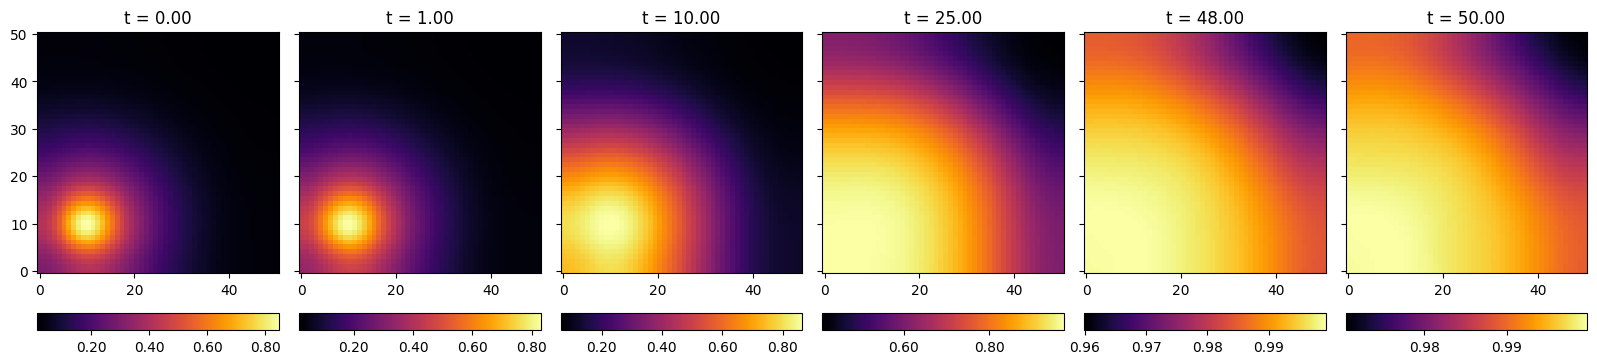

In [34]:
u_est = lambda t, x: u(t, x, {"nn_params":params["nn_params"], "eq_params":{"g":g, "D":jnp.array([1.]), "r":jnp.array([0.15])}})
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(20, 20*len(times))
)

## Compare the results with a PDE solver (Diffrax and finite differences method)

The `jinns.experimental` module contains helper class and functions to solve reaction-diffusion equation with finite differences.

Mostly adapted from [https://docs.kidger.site/diffrax/examples/nonlinear_heat_pde/](https://docs.kidger.site/diffrax/examples/nonlinear_heat_pde/).

In [30]:
from jinns.experimental import SpatialDiscretisation, plot_diffrax_solution, reaction_diffusion_2d_vector_field
import diffrax

# Spatial discretisation
xmin, xmax = 0, 50
ymin, ymax = 0, 50
nx, ny = 50, 50

y0 = SpatialDiscretisation.discretise_fn(xmin, xmax, ymin, ymax, nx, ny, u0)

# Temporal discretisation
times = jnp.linspace(tmin, Tmax, 10)

# Tolerances for non-stiff problems
rtol = 1e-3
atol = 1e-6
# Tolerances for stiff problems (along with using float64)
# rtol = 1e-7
# atol = 1e-9
stepsize_controller = diffrax.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=1
)

solver = diffrax.Tsit5()
max_steps = int(1e6)
saveat = (times,)

xbounds = (xmin, xmax)
ybounds = (ymin, ymax)

diffeqsolve_kwargs = {
    "t0": tmin,
    "t1": Tmax,
    "dt0": None,
    "y0": y0,
    "saveat": diffrax.SaveAt(ts=times),
    "stepsize_controller": stepsize_controller,
    "max_steps": max_steps,
    "solver": diffrax.Tsit5(),
}

r=0.15,D=1.00


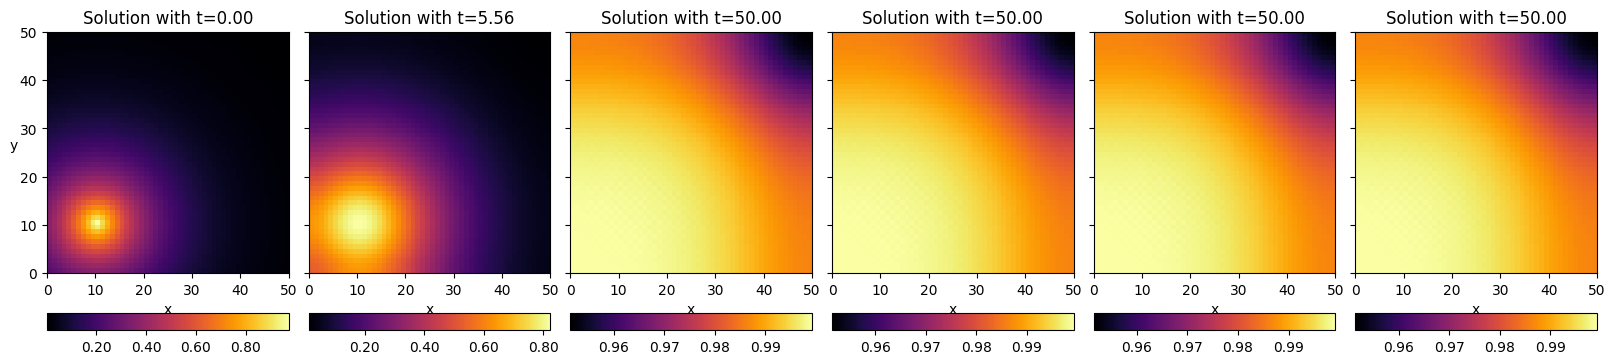

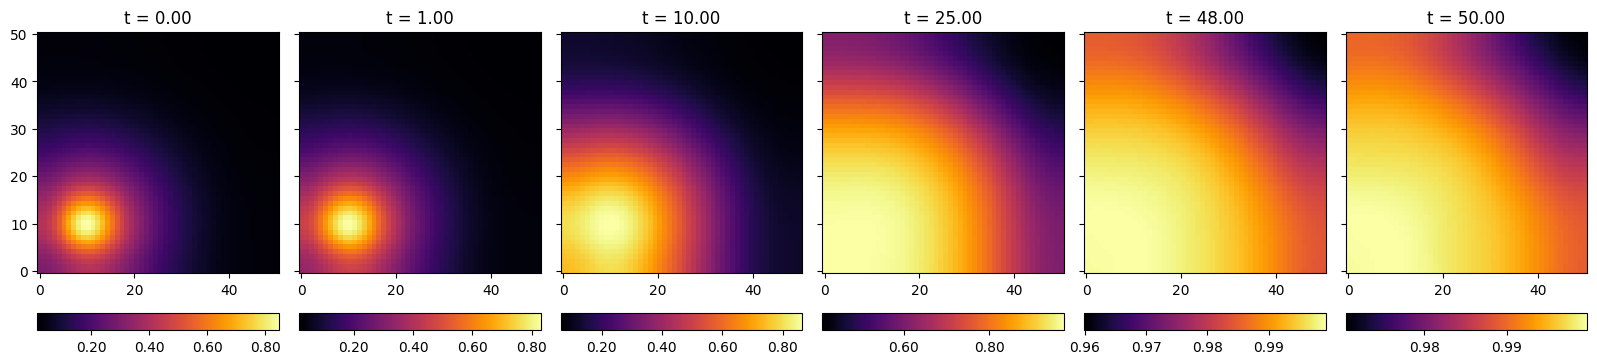

In [37]:
D = jnp.array(1.)
r = jnp.array(0.15)

diffeqsolve_kwargs["args"] = (D, r) # This is where we feed the vector field additional parameters

# The following instructions are represent the classical diffrax procedure
term = diffrax.ODETerm(reaction_diffusion_2d_vector_field)
diffrax_solution = diffrax.diffeqsolve(term, **diffeqsolve_kwargs)
print(f"r={float(r):.2f},D={float(D):.2f}")
plot_diffrax_solution(diffrax_solution, xbounds, ybounds, t_ind=t_ind)
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(20, 20*len(times))
)

## $D=0.1$ and $r=0.1$

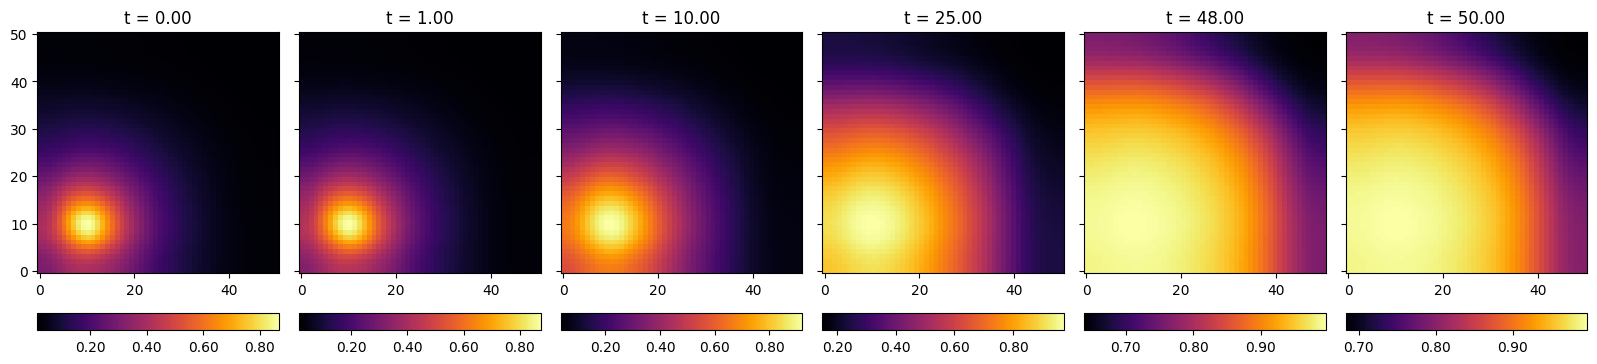

In [40]:
u_est = lambda t, x: u(t, x, {"nn_params":params["nn_params"], "eq_params":{"g":g, "D":jnp.array([0.1]), "r":jnp.array([0.1])}})
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(20, 20*len(times))
)

r=0.10,D=0.10


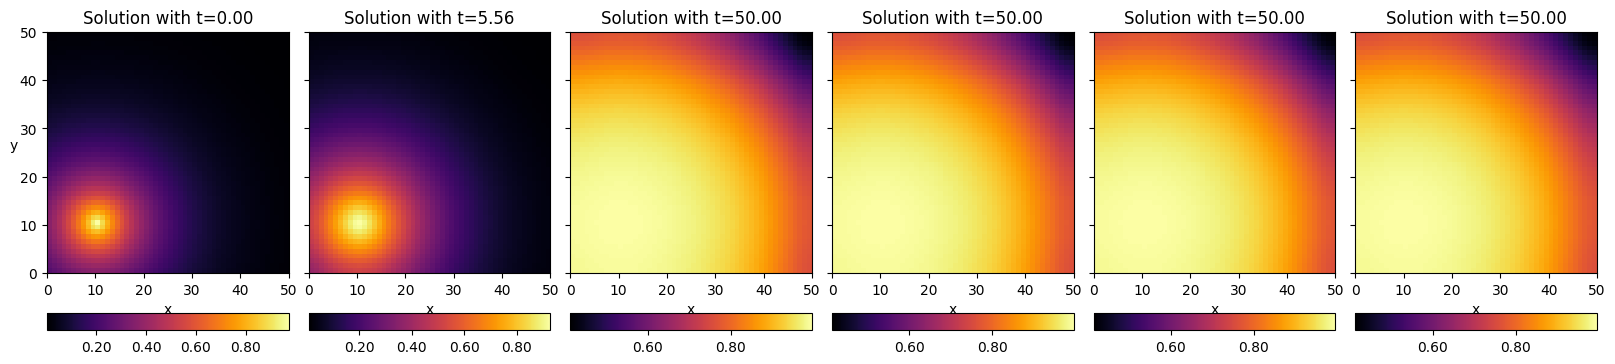

In [41]:
D = jnp.array(0.1)
r = jnp.array(0.1)

diffeqsolve_kwargs["args"] = (D, r)

term = diffrax.ODETerm(reaction_diffusion_2d_vector_field)
diffrax_solution = diffrax.diffeqsolve(term, **diffeqsolve_kwargs)
print(f"r={float(r):.2f},D={float(D):.2f}")
plot_diffrax_solution(diffrax_solution, xbounds, ybounds, t_ind=t_ind)

## $D=0.05$ and $r=0.05$

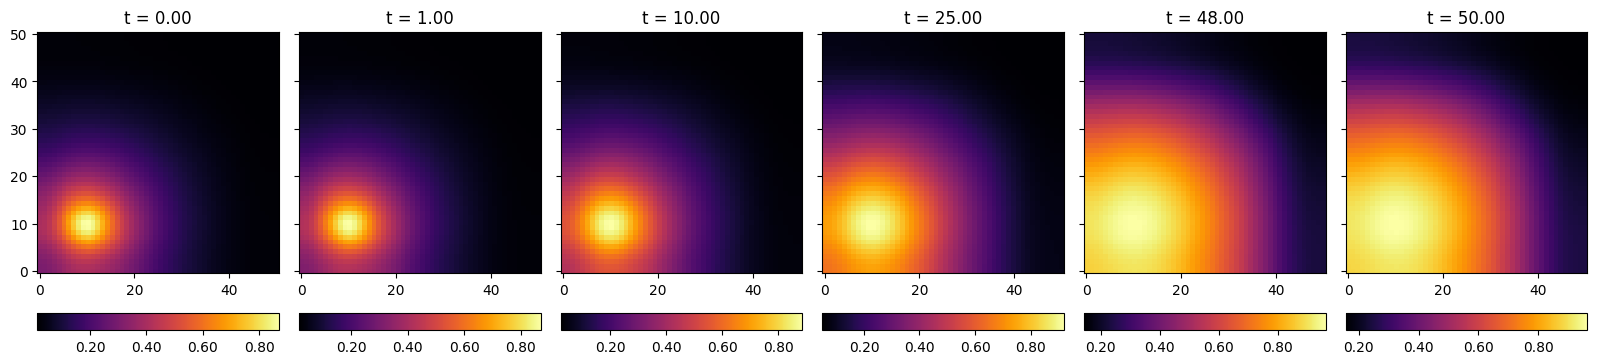

In [44]:
u_est = lambda t, x: u(t, x, {"nn_params":params["nn_params"], "eq_params":{"g":g, "D":jnp.array([0.05]), "r":jnp.array([0.05])}})
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(20, 20*len(times))
)

r=0.05,D=0.05


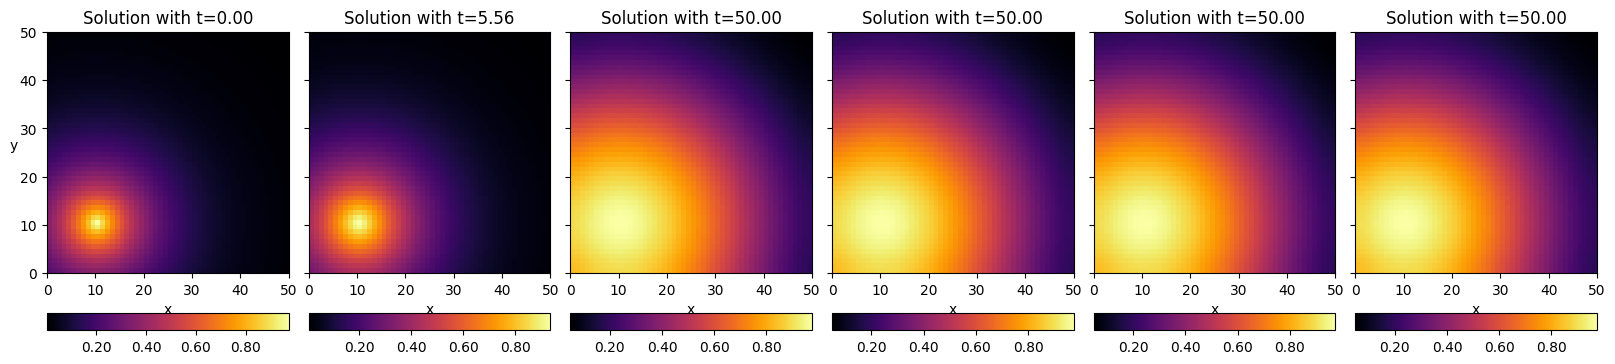

In [45]:
D = jnp.array(0.05)
r = jnp.array(0.05)

diffeqsolve_kwargs["args"] = (D, r)

term = diffrax.ODETerm(reaction_diffusion_2d_vector_field)
diffrax_solution = diffrax.diffeqsolve(term, **diffeqsolve_kwargs)
print(f"r={float(r):.2f},D={float(D):.2f}")
plot_diffrax_solution(diffrax_solution, xbounds, ybounds, t_ind=t_ind)